In [1]:
import ROOT as r
import root_numpy as rn
import pickle
import numpy as np
import matplotlib.pyplot as plt
import array as array
from architectures.data_processing import *

/home/hep/davide/miniconda3/envs/root_env/lib/ROOT.py:301: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return _orig_ihook( name, *args, **kwds )


In [2]:
l_index=1
l_flv=['e','mu']
MC_Dplus_sig_dict, MC_Ds_sig_dict, _ = load_datasets(l_index)


In [3]:
Dplus_M=np.array([MC_Dplus_sig_dict["Dplus_ConsD_M"][i][0] for i in range(len(MC_Dplus_sig_dict["Dplus_ConsD_M"]))])
Ds_M=np.array([MC_Ds_sig_dict["Ds_ConsD_M"][i][0] for i in range(len(MC_Ds_sig_dict["Ds_ConsD_M"]))])

data=np.concatenate((Dplus_M,Ds_M),axis=0)

In [4]:
#cut on mass
cut_indices=[]

lower_mass_cut=1930
upper_mass_cut=2030

for i in range(len(data)):
    if lower_mass_cut<data[i]<upper_mass_cut:
        cut_indices.append(i)
        
data_cut=data[cut_indices]/1000.  

lower_mass_cut/=1000.
upper_mass_cut/=1000.

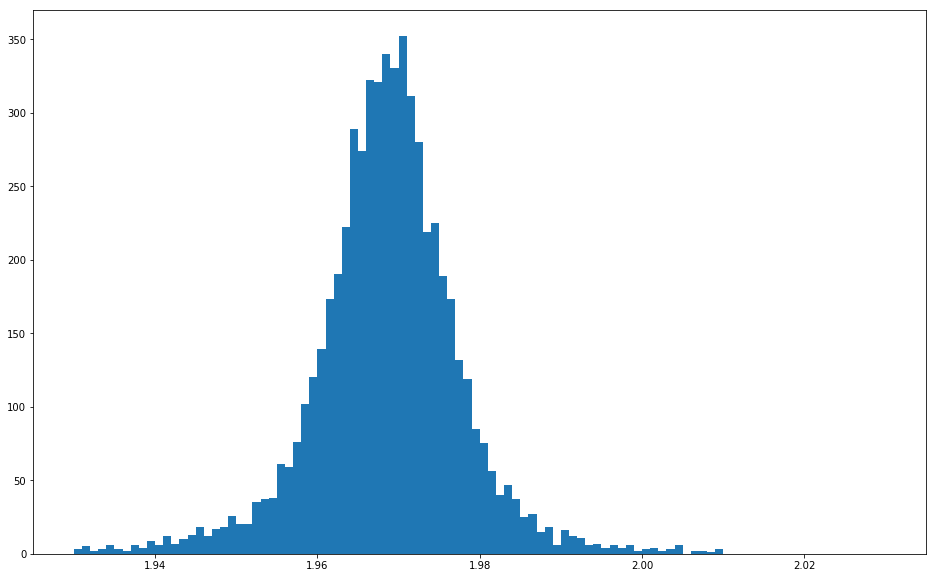

In [5]:
data_array=np.array([data_cut[i] for i in range(len(data_cut))], dtype=[('D_sel_M', np.float32)])

plt.hist(data_cut,range=(lower_mass_cut,upper_mass_cut),bins=100);
fig=plt.gcf();

fig.set_size_inches(16,10)

In [6]:
rn.array2root(data_array,
              filename='/disk/lhcb_data/davide/Rphipi/selected_data/'+l_flv[l_index]+l_flv[l_index]+'/sel_data_NN_'+l_flv[l_index]+l_flv[l_index]+'.root',
              treename='D_M',
              mode='recreate',
             )
f=r.TFile('/disk/lhcb_data/davide/Rphipi/selected_data/'+l_flv[l_index]+l_flv[l_index]+'/sel_data_NN_'+l_flv[l_index]+l_flv[l_index]+'.root')
tree=f.Get("D_M") 

In [7]:
mass = np.array([0],dtype=np.float32)
branch = tree.GetBranch("D_sel_M")
branch.SetAddress(mass)

num_entries=tree.GetEntries()
m = r.RooRealVar("m","m",lower_mass_cut,upper_mass_cut)
l = r.RooArgSet(m)
data_hist = r.RooDataSet("data histogram", "data", l)


for i in range(num_entries):
    tree.GetEvent(i)
    r.RooAbsRealLValue.__assign__(m, mass[0])
    data_hist.add(l, 1.0)

In [8]:
#Creating the signal PDF


mean_dplus= r.RooRealVar("mean_D+","mean_D+",1.87,1.77,1.97)
sigma_dplus = r.RooRealVar("sigma_D+","sigma_D+",0.020,0.,0.2)
alpha_dplus = r.RooRealVar("alpha_D+","alpha_D+",0.020,-10.,10.)
n_dplus = r.RooRealVar("n_D+","n_D+",0.020,-50.,50.)
sig_dplus = r.RooCBShape("signal_D+","signal_D+", m, mean_dplus, sigma_dplus, alpha_dplus, n_dplus)


In [8]:
#Creating the signal PDF

mean_ds= r.RooRealVar("mean_Ds","mean_Ds",1.97,1.87,2.07)
sigma_ds = r.RooRealVar("sigma_Ds","sigma_Ds",0.020,0.,0.2)
alpha_ds = r.RooRealVar("alpha_Ds","alpha_Ds",0.020,-10.,10.)
n_ds = r.RooRealVar("n_Ds","n_Ds",0.020,-50.,50.)
sig_ds = r.RooCBShape("signal_Ds","signal_Ds", m, mean_ds, sigma_ds, alpha_ds, n_ds)


In [10]:
#coef0 = r.RooRealVar("c0","coefficient #0",1.0,-1.,1)
#coef1 = r.RooRealVar("c1","coefficient #1",0.1,-1.,1)
#coef2 = r.RooRealVar("c2","coefficient #2",-0.1,-1.,1)
#bkg = r.RooChebychev("bkg","background p.d.f.",m,r.RooArgList(coef0,coef1,coef2))

In [9]:
#Add 2 sources of signal

# first add the sig and the peak together with fraction fpeak
ns = r.RooRealVar("# of Ds sig events","# of Ds sig events",100.,0.,40000.)
#nplus = r.RooRealVar("# of Dplus sig events","# of Dplus sig events",100.,0.,40000.)
#nbkg = r.RooRealVar("# of bkg events","# of bkg events",100.,0.,40000.)
# sigpeak(x) = fpeak*sig(x) + (1-fpeak)*bkg(x)
model = r.RooAddPdf("model","two mass peaks",r.RooArgList(sig_ds),r.RooArgList(ns))


In [10]:
model.fitTo(data_hist,r.RooFit.Extended())



xframe = m.frame(r.RooFit.Title("Fit to "+l_flv[l_index]+" data"))

#bkg_component = r.RooArgSet(bkg)
data_hist.plotOn(xframe)
#model.plotOn(xframe,r.RooFit.Components(bkg_component),r.RooFit.LineStyle(2))
model.plotOn(xframe)
#sigpeaks.plotOn(xframe)
xframe.Draw()

In [13]:
#NB=nbkg.getVal()
NS=ns.getVal()
Nplus=nplus.getVal()

if l_index==0:
    Nsig_from_MC=1466+1974
if l_index==1:
    Nsig_from_MC=5881+9639
    

In [14]:
NS+Nplus

15520.023435679977

In [15]:
Nsig_from_MC

15520